In [ ]:
# === CELL 1: Install Libraries ===
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q accelerate peft bitsandbytes qwen-vl-utils
print("✅ Libraries installed")

In [4]:
# === CELL 2: Load Base Model + Your Adapter (FIXED) ===
import os
import torch
import torch.distributed as dist
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from peft import PeftModel

# --- THE FIX: TRICK THE MODEL INTO THINKING DISTRIBUTED IS ON ---
# Qwen2-VL tries to check for multiple GPUs. We tell it "World Size = 1".
if not dist.is_initialized():
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    # Use "gloo" as backend since it's robust for this dummy setup
    dist.init_process_group(backend="gloo", rank=0, world_size=1)
# ----------------------------------------------------------------

# 1. PATH TO YOUR UPLOADED CHECKPOINT
# (Double check this path matches your Kaggle Input!)
ADAPTER_PATH = "/kaggle/input/new-qwn" 

# 2. Configs
model_id = "Qwen/Qwen2-VL-2B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

print("🔄 Loading Base Model...")
# 3. Load Base Model
# device_map="cuda:0" ensures we stay on the first GPU
base_model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="cuda:0", 
    torch_dtype=torch.float16,
)

print(f"🔄 Loading Adapter from: {ADAPTER_PATH}...")
# 4. Load YOUR Fine-Tuned Adapter
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)

# Fix processor loading
processor = AutoProcessor.from_pretrained(model_id, min_pixels=256*28*28, max_pixels=1024*28*28)

print("✅ Model Successfully Assembled!")

🔄 Loading Base Model...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/729 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

🔄 Loading Adapter from: /kaggle/input/new-qwn...


/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['alora_invocation_tokens', 'arrow_config', 'ensure_weight_tying', 'peft_version', 'target_parameters'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Model Successfully Assembled!


In [7]:
# === CELL 3: Run Inference ===
from qwen_vl_utils import process_vision_info
from PIL import Image
import requests
from io import BytesIO

def test_model(image_path_or_url, instruction):
    # Load Image
    if image_path_or_url.startswith("http"):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path_or_url)
        
    # Create the Prompt (SAME FORMAT AS TRAINING)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": instruction},
            ],
        }
    ]

    # Process Inputs
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to("cuda")

    # Generate
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,  # Greedy decoding (Best for strict JSON)
        temperature=0.0   # Turn off randomness
    )
    
    # Decode
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    return output_text[0]

# --- TEST IT HERE ---
# Use a random UI image or upload one of your validation images
# Ideally, upload one from your dataset to Kaggle
TEST_IMAGE = "/kaggle/input/iknowitsok/idk.png" # <--- REPLACE THIS
TEST_PROMPT = "Click Email address"                  # <--- REPLACE THIS with your dataset instruction

print("🤔 Thinking...")
result = test_model(TEST_IMAGE, TEST_PROMPT)

print("\n" + "="*40)
print(f"📝 Instruction: {TEST_PROMPT}")
print("-" * 40)
print(f"🤖 Model Output:\n{result}")
print("="*40)

🤔 Thinking...

📝 Instruction: Click Email address
----------------------------------------
🤖 Model Output:
click(point='<point>729 238</point>')


🤖 Raw Output: click(point='<point>500 662</point>')
📍 Mapped Point: (954.0, 535.6) on image size 1908x809


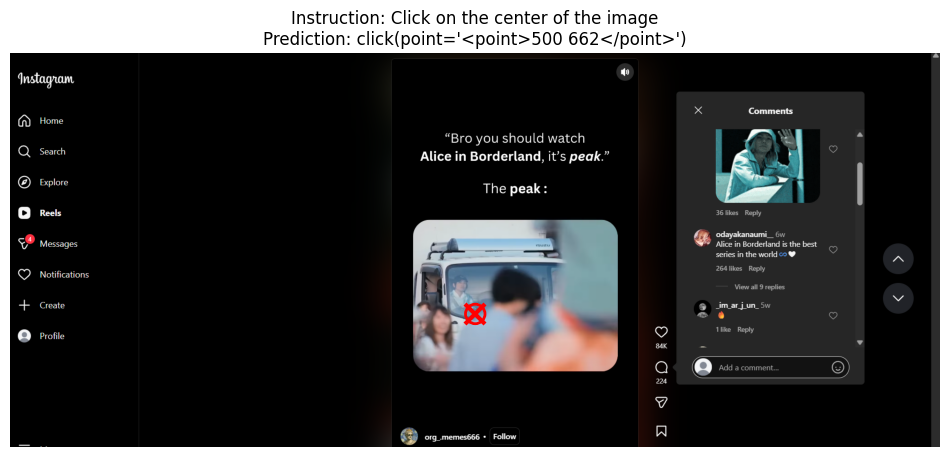

In [62]:
# === CELL 4: Test & Visualize (Complete) ===
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def get_point_from_output(output_text):
    """
    Parses the Qwen2-VL output format: click(point='<point>X Y</point>')
    Returns (x, y) as integers or None if not found.
    """
    # Regex to find numbers inside <point> tags
    match = re.search(r"<point>(\d+)\s+(\d+)</point>", output_text)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None

def visualize_prediction(image_path, instruction):
    # 1. Load Image
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    
    # 2. Prepare Prompt
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": instruction},
            ],
        }
    ]

    # 3. Run Inference
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to("cuda") # Use cuda:0 if you set device_map="cuda:0" earlier

    # Generate
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,
        temperature=0.0
    )
    
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]
    
    print(f"🤖 Raw Output: {output_text}")

    # 4. Parse Coordinates (0-1000 scale)
    norm_coords = get_point_from_output(output_text)
    
    # 5. Visualize
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    
    if norm_coords:
        norm_x, norm_y = norm_coords
        
        # Qwen2-VL uses 1000x1000 normalization. We must scale to real image size.
        real_x = (norm_x / 1000) * width
        real_y = (norm_y / 1000) * height
        
        print(f"📍 Mapped Point: ({real_x:.1f}, {real_y:.1f}) on image size {width}x{height}")
        
        # Draw a red cross and a circle
        plt.plot(real_x, real_y, 'rx', markersize=15, markeredgewidth=3)  # Red X
        circle = patches.Circle((real_x, real_y), radius=20, edgecolor='r', facecolor='none', linewidth=2)
        plt.gca().add_patch(circle)
        plt.title(f"Instruction: {instruction}\nPrediction: {output_text}")
    else:
        plt.title(f"Instruction: {instruction}\n(No coordinates found in output)")
        
    plt.axis('off')
    plt.show()

# --- RUN IT ---
TEST_IMAGE_PATH = "/kaggle/input/instagrammmmmm/Screenshot 2025-11-19 095705.png"  # <--- Your Image
TEST_INSTRUCTION = "Click on the center of the image"         # <--- Your Instruction

visualize_prediction(TEST_IMAGE_PATH, TEST_INSTRUCTION)